In [1]:
library(readr)
library(dplyr, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(purrr)
library(ggplot2)
library(Matrix, warn.conflicts = FALSE)
library(uwot)

In [2]:
options(repr.plot.res = 300)

In [3]:
load("../data/validclusmod.RData")

In [4]:
print(validclusmod)

# A tibble: 2 x 3
  sex    residmod          clusmod         
  <chr>  <list>            <list>          
1 Female <tibble [10 x 6]> <tibble [6 x 4]>
2 Male   <tibble [10 x 6]> <tibble [5 x 4]>


In [5]:
cluscolmap <- validclusmod %>%
    transmute(
        clusmod = map(clusmod, select, Cluster = validclus_name)
    ) %>%
    unnest(clusmod) %>%
    unique %>%
    mutate(ClusCol = scales::hue_pal()(n()))
cluscolmap

Cluster,ClusCol
<chr>,<chr>
BC,#F8766D
DHT,#B79F00
DAL,#00BA38
DLT,#00BFC4
DIS,#619CFF
DHG,#F564E3


In [6]:
validclusmod <- validclusmod %>%
    mutate(
        umapmod = map(
            sex,
            ~load_uwot(paste0("../data/ukb/umapmod_", .x))
        )
    )
print(validclusmod)

# A tibble: 2 x 4
  sex    residmod          clusmod          umapmod          
  <chr>  <list>            <list>           <list>           
1 Female <tibble [10 x 6]> <tibble [6 x 4]> <named list [26]>
2 Male   <tibble [10 x 6]> <tibble [5 x 4]> <named list [26]>


In [7]:
validclusmod <- validclusmod %>%
    mutate(
        residtab = map(
            umapmod,
            ~map(
                1:.x$nn_index$ann$getNItems(),
                function(i){
                    .x$nn_index$ann$getItemsVector(i-1)
                }
            )
        ),
        residtab = map(residtab, do.call, what = rbind)
    )
print(validclusmod)

# A tibble: 2 x 5
  sex    residmod          clusmod          umapmod           residtab  
  <chr>  <list>            <list>           <list>            <list>    
1 Female <tibble [10 x 6]> <tibble [6 x 4]> <named list [26]> <dbl[...]>
2 Male   <tibble [10 x 6]> <tibble [5 x 4]> <named list [26]> <dbl[...]>


In [389]:
mahadat <- validclusmod %>%
    transmute(
        sex,
        maha_umap = map2(
            umapmod, residtab,
            ~data.frame(
                .x$embedding,
                PMaha = pchisq(
                    mahalanobis(
                        x = .y,
                        center = colMeans(.y),
                        cov = cov(.y)
                    ),
                    df = ncol(.y),
                    lower.tail = FALSE
                )
            )
        )
    ) %>%
    unnest(maha_umap)
head(mahadat)

sex,X1,X2,PMaha
<chr>,<dbl>,<dbl>,<dbl>
Female,-0.1854294,0.8024553,0.8327955
Female,0.3772524,0.4998869,0.9178505
Female,-0.3064628,0.2833304,0.5508684
Female,0.7155038,0.4197675,0.2695355
Female,-0.2389937,0.7671190,0.6864054
Female,-0.6407928,0.4642103,0.9266649


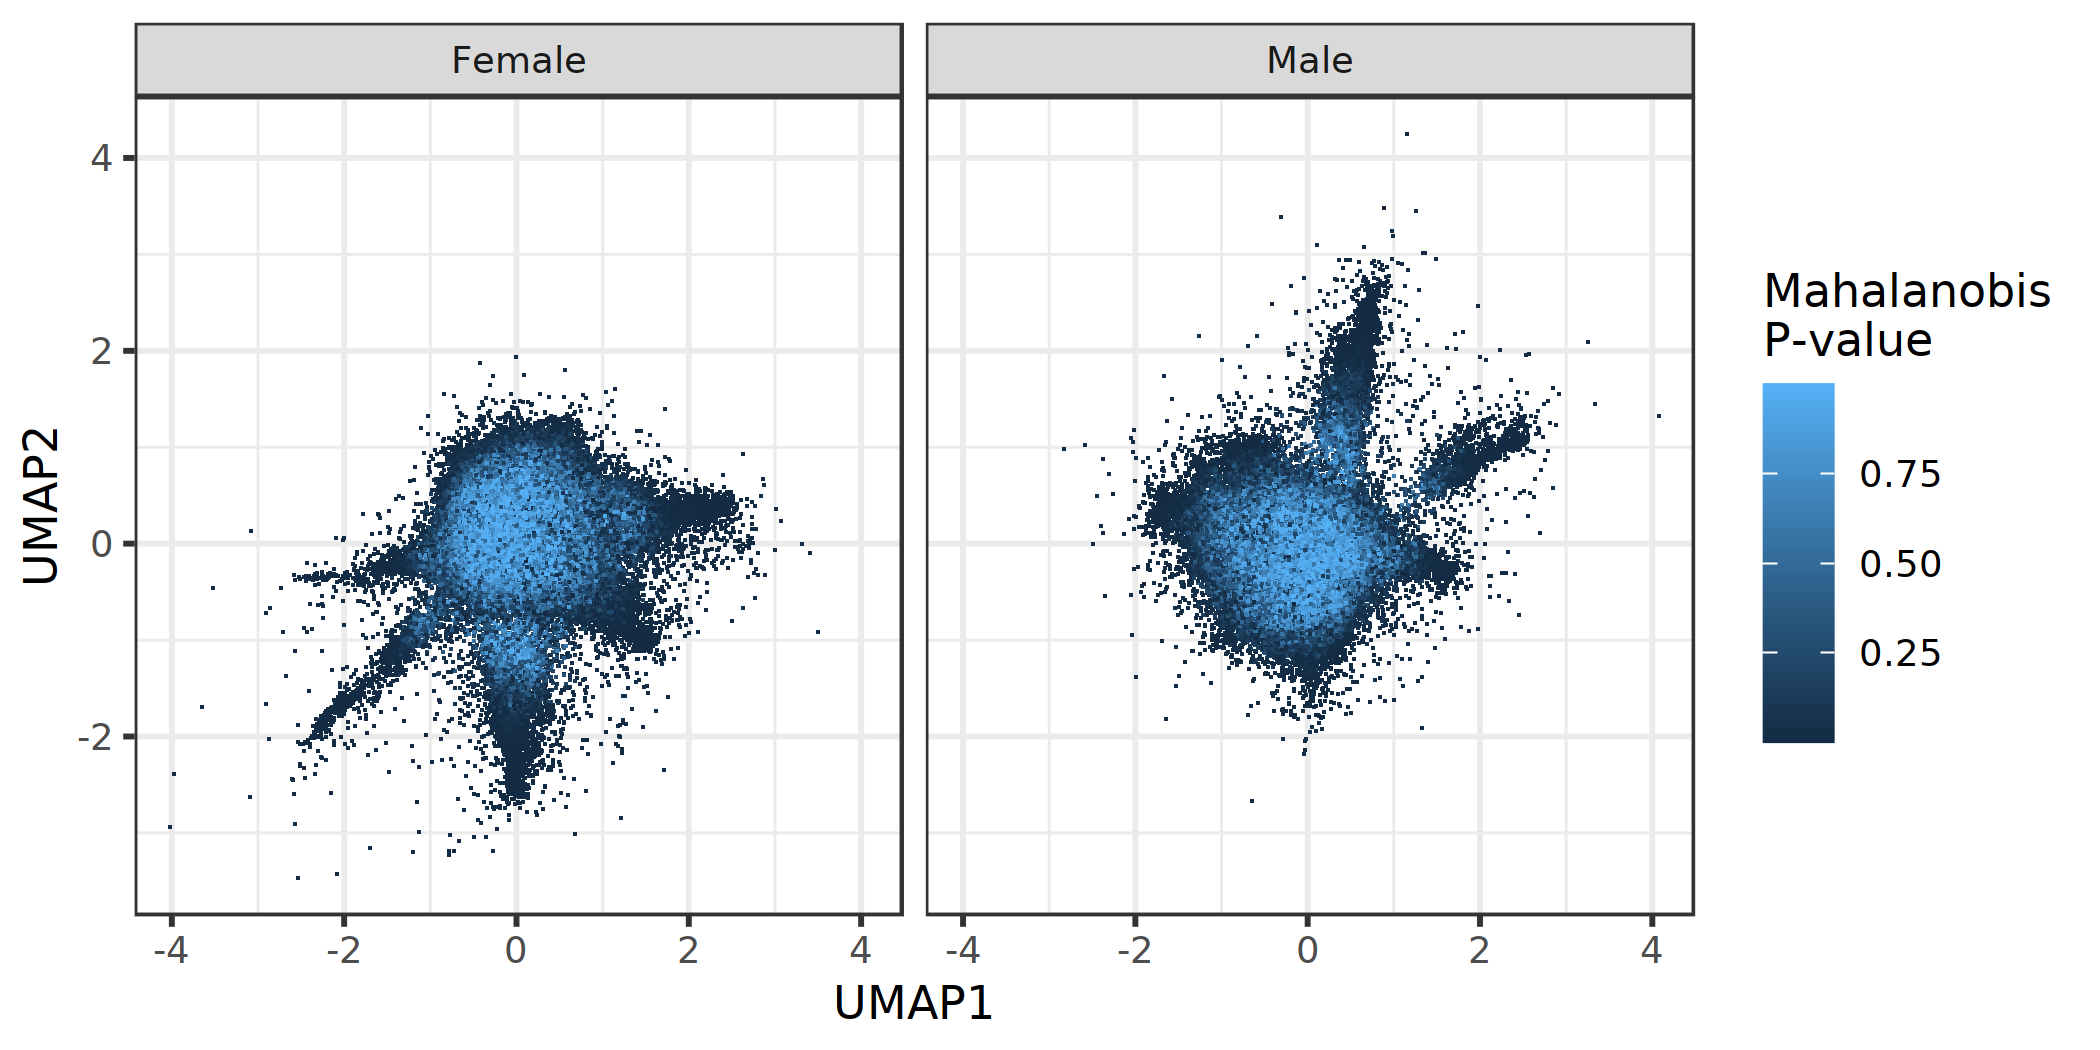

In [390]:
mahadat %>%
    ggplot(aes(X1, X2)) +
    geom_point(aes(color = PMaha), shape = ".") +
    facet_wrap(~sex) +
    theme_bw() +
    labs(x = "UMAP1", y = "UMAP2", color = "Mahalanobis\nP-value")

In [402]:
mahares <- mahadat %>%
    group_by(sex) %>%
    count(PMaha < 0.05) %>%
    mutate(
        prop = n/sum(n)
    )
mahares

sex,PMaha < 0.05,n,prop
<chr>,<lgl>,<int>,<dbl>
Female,FALSE,69373,0.8985325
Female,TRUE,7834,0.1014675
Male,FALSE,60866,0.8963537
Male,TRUE,7038,0.1036463


In [400]:
summarise(
    mahares,
    binomres = list(binom.test(n, p = .95))
) %>%
    {setNames(.$binomres, .$sex)}

$Female

	Exact binomial test

data:  n
number of successes = 69373, number of trials = 77207, p-value <
2.2e-16
alternative hypothesis: true probability of success is not equal to 0.95
95 percent confidence interval:
 0.8963812 0.9006538
sample estimates:
probability of success 
             0.8985325 


$Male

	Exact binomial test

data:  n
number of successes = 60866, number of trials = 67904, p-value <
2.2e-16
alternative hypothesis: true probability of success is not equal to 0.95
95 percent confidence interval:
 0.8940368 0.8986366
sample estimates:
probability of success 
             0.8963537 



In [8]:
validclusmod <- validclusmod %>%
    mutate(
        probtab = map2(
            residtab, clusmod,
            function(RESIDDF, CLUSMOD){
                pdfs <- mapply(
                    function(mu, covmat){ mvtnorm::dmvnorm(RESIDDF, mu, covmat) },
                    CLUSMOD$validclus_centers, 
                    CLUSMOD$validclus_covmats
                )
                L <- pdfs %*% diag(CLUSMOD$validclus_weights)
                colnames(L) <- paste0("prob", CLUSMOD$validclus_name)
                tibble(data.frame(L / rowSums(L)))
            }
        )
    )
print(validclusmod)

# A tibble: 2 x 6
  sex    residmod          clusmod          umapmod      residtab   probtab 
  <chr>  <list>            <list>           <list>       <list>     <list>  
1 Female <tibble [10 x 6]> <tibble [6 x 4]> <named list> <dbl[...]> <tibble>
2 Male   <tibble [10 x 6]> <tibble [5 x 4]> <named list> <dbl[...]> <tibble>


In [408]:
maxprobdat <- validclusmod %>%
    transmute(
        sex,
        maxprob = map(probtab, mutate, eid = row_number()),
        maxprob = map(maxprob, pivot_longer, -eid, names_to = "clus", values_to = "prob"),
        maxprob = map(maxprob, group_by, eid),
        maxprob = map(maxprob, slice_max, prob, with_ties = FALSE)
    ) %>%
    unnest(maxprob)
head(maxprobdat)

sex,eid,clus,prob
<chr>,<int>,<chr>,<dbl>
Female,1,probDHT,0.8986830
Female,2,probDHT,0.5636498
Female,3,probBC,0.9888657
Female,4,probBC,0.9440884
Female,5,probBC,0.7938072
Female,6,probBC,0.9836438


In [409]:
maxprobdat %>%
    summarise(
        Mprob = mean(prob), 
        SDprob = sd(prob),
        MinProb = min(prob),
        MaxProb = max(prob),
        p25 = quantile(prob, probs = .25),
        p50 = quantile(prob, probs = .5),
        p75 = quantile(prob, probs = .75)
    )

Mprob,SDprob,MinProb,MaxProb,p25,p50,p75
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9131206,0.1237547,0.3146737,1,0.8912369,0.9719334,0.9920216


In [410]:
maxprobdat %>%
    group_by(sex, clus) %>%
    summarise(
        Mprob = mean(prob), 
        SDprob = sd(prob),
        MinProb = min(prob),
        MaxProb = max(prob),
        p25 = quantile(prob, probs = .25),
        p50 = quantile(prob, probs = .5),
        p75 = quantile(prob, probs = .75)
    )

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,clus,Mprob,SDprob,MinProb,MaxProb,p25,p50,p75
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,probBC,0.9157235,0.1130126,0.3744094,1.0000000,0.8989072,0.9660178,0.9857263
Female,probDAL,0.8432835,0.1653127,0.3484663,1.0000000,0.7127362,0.9085804,0.9908365
Female,probDHG,0.8967230,0.1508776,0.4324982,1.0000000,0.8221639,0.9905449,0.9999950
Female,probDHT,0.8041879,0.1576479,0.3717613,0.9999876,0.6710930,0.8363949,0.9526369
Female,probDIS,0.9002585,0.1423843,0.5005353,1.0000000,0.8320429,0.9857208,0.9998577
Female,probDLT,0.8645887,0.1644708,0.3146737,1.0000000,0.7496424,0.9499110,0.9990865
Male,probBC,0.9404395,0.1015949,0.3423771,1.0000000,0.9413964,0.9850386,0.9955378
Male,probDAL,0.8083104,0.1643601,0.3475382,0.9999578,0.6652318,0.8442033,0.9657451
Male,probDHG,0.9079220,0.1433705,0.4457909,1.0000000,0.8589344,0.9935256,0.9999740


In [303]:
validclusmod %>%
    transmute(
        sex,
        RelEnt = map_dbl(
            probtab,
            ~{
                pp <- pmax(as.matrix(.x), .Machine$double.xmin)
                ent <- -sum(rowSums(pp * log(pp)))
                1 - ent / (nrow(pp) * log(ncol(pp)))
            }
        )
    )

sex,RelEnt
<chr>,<dbl>
Female,0.8481525
Male,0.8754381


In [9]:
embeddf <- validclusmod %>%
    transmute(
        sex, 
        umapmod = map2(
            umapmod, probtab,
            ~data.frame(.x$embedding, .y)
        ),
        umapmod = map(
            umapmod,
            pivot_longer,
            -c(X1, X2),
            names_to = "Cluster",
            values_to = "ClusProb"
        )
    ) %>%
    unnest(umapmod) %>%
    mutate(Cluster = gsub("prob", "", Cluster)) %>%
    inner_join(cluscolmap, by = "Cluster")
head(embeddf)

sex,X1,X2,Cluster,ClusProb,ClusCol
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
Female,-0.1854294,0.8024553,BC,1.004198e-01,#F8766D
Female,-0.1854294,0.8024553,DHT,8.986830e-01,#B79F00
Female,-0.1854294,0.8024553,DAL,8.248314e-08,#00BA38
Female,-0.1854294,0.8024553,DLT,5.747241e-04,#00BFC4
Female,-0.1854294,0.8024553,DIS,2.590887e-04,#619CFF
Female,-0.1854294,0.8024553,DHG,6.334464e-05,#F564E3


In [10]:
embedplot <- embeddf %>%
    ggplot(aes(X1, X2)) +
    facet_wrap(~sex) +
    theme_bw()

In [11]:
for(CLUS in unique(embeddf$Cluster)){
    DAT <- embeddf %>%
        filter(Cluster == CLUS) %>%
        group_by(sex) %>%
        arrange(desc(ClusProb), .by_group = TRUE) %>%
        mutate(
            csum = cumsum(ClusProb),
            csumc = cut(
                csum,
                c(-Inf, sum(ClusProb) * .5,  sum(ClusProb) * .8, sum(ClusProb) * .95),
                labels = FALSE
            ),
            csumc = case_when(
                csumc == 1 ~ .1,
                csumc == 2 ~ .025,
                csumc == 3 ~ .001
            )
        ) %>%
        ungroup %>%
        drop_na
    embedplot <- embedplot + 
        geom_point(data = DAT, aes(alpha = csumc, color = ClusCol), shape = ".")
}

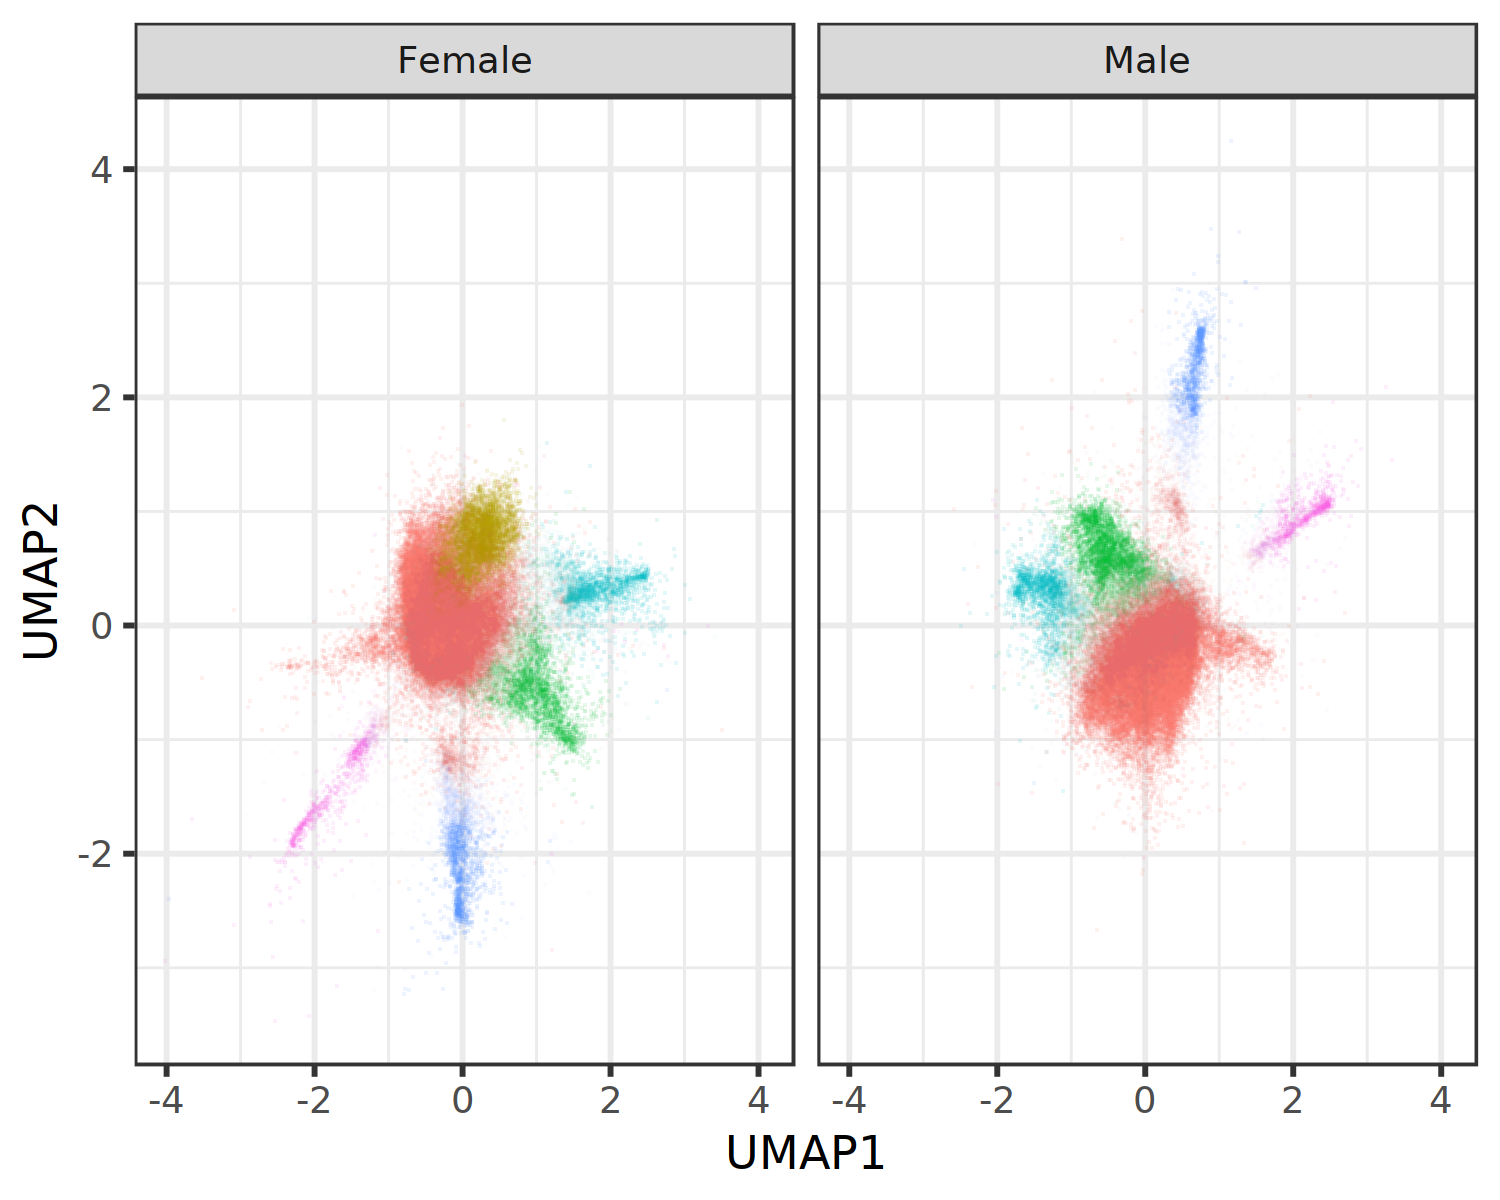

In [12]:
options(repr.plot.width = 5, repr.plot.height = 4)
embedplot <- embedplot +
    scale_alpha_identity() +
    scale_color_identity() +
    labs(x = "UMAP1", y = "UMAP2") +
    theme_bw()
embedplot

In [13]:
cluscent <- validclusmod %>%
    transmute(
        sex,
        NewD = map(clusmod, pull, validclus_centers),
        NewD = map(NewD, do.call, what = rbind),
        NewD = map2(clusmod, NewD, ~data.frame(Cluster = .x$validclus_name, .y))
    ) %>%
    unnest(NewD)
cluscent

sex,Cluster,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,BC,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000
Female,DHT,-0.44481334,1.725202876,1.62462466,-0.26657151,-0.06615801,-0.2454231,0.08850782,-0.34136707,-0.15623660,-0.01538914
Female,DAL,0.70376602,0.036024481,0.07912553,0.23925213,-0.16253036,-0.1079424,-0.94833520,3.27500765,0.67305608,-0.09580950
Female,DLT,0.31819538,-0.007265161,0.11213304,3.88799677,-0.16347297,-0.0493273,-0.16425835,0.06414769,0.03819812,-0.06887853
Female,DIS,0.01728378,-0.042601373,-0.03987321,-0.26410277,-0.11786673,4.1328935,-0.17646000,-0.09260605,-0.20328917,-0.08577053
Female,DHG,0.28792693,-0.145682550,-0.35836381,0.04707222,-0.22191370,-0.1732186,-0.32762038,0.11481517,-0.68337380,4.73720072
Male,BC,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000
Male,DAL,0.29265662,-0.046161460,0.05984001,0.21370670,-0.11413500,-0.1657179,-0.75578795,2.49151559,0.39735872,-0.24959776
Male,DLT,0.22400581,0.027290015,0.19474430,3.11419728,-0.14937316,-0.1244352,-0.17240516,0.06501433,0.12913152,-0.06119104


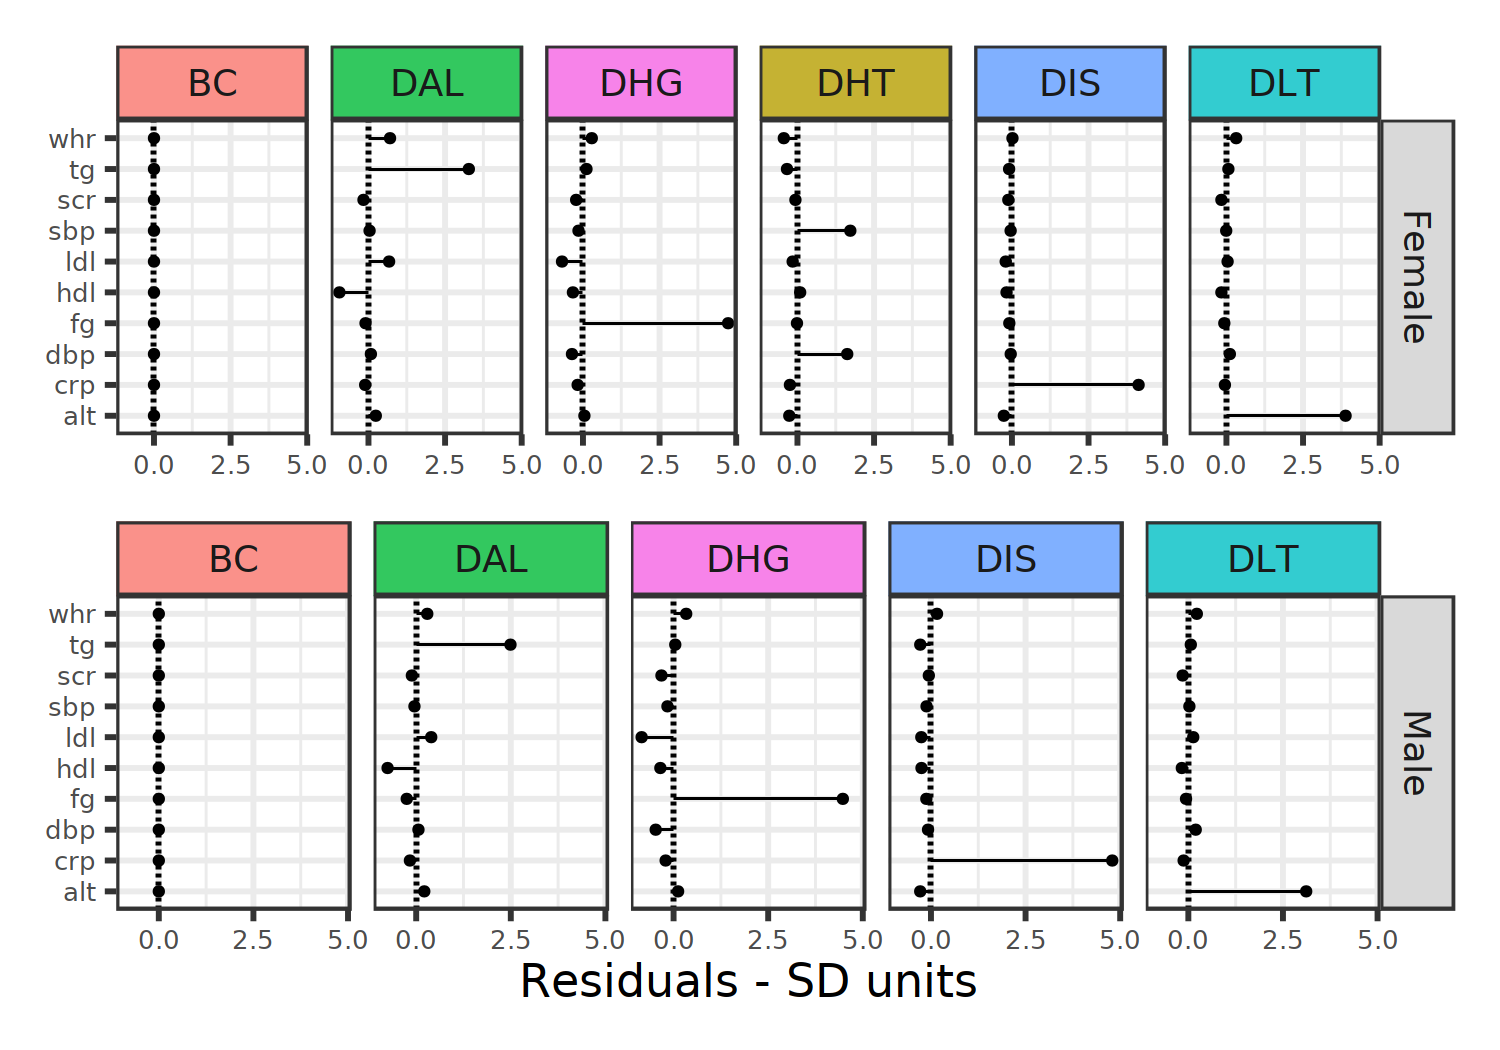

In [130]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
cluscentplot <- cluscent %>%
    pivot_longer(-c(sex, Cluster)) %>%
    inner_join(cluscolmap, by = "Cluster") %>%
    nest(D = -sex) %>%
    mutate(
        D = map2(
            D, sex,
            ~.x %>%
                mutate(sex = .y) %>%
                ggplot(aes(value, name)) +
                geom_vline(xintercept = 0, lty = "dashed") +
                geom_segment(aes(xend = 0, yend = name), linewidth = .25) +
                geom_point(size = .5) +
                ggh4x::facet_grid2(
                    sex ~ Cluster, 
                    strip = ggh4x::strip_themed(
                        background_x = ggh4x::elem_list_rect(
                            fill = alpha(
                                .x %>%
                                    select(Cluster, ClusCol) %>%
                                    unique %>%
                                    arrange(Cluster) %>%
                                    pull(ClusCol),
                                .8
                            )
                        )
                    )
                ) +
                labs(x = "Residuals - SD units", y = NULL) +
                scale_x_continuous(n.breaks = 3)
        )
    ) %>%
    pull(D) %>%
    modify_at(1, ~.x + labs(x = NULL)) %>%
    patchwork::wrap_plots(ncol = 1) &
    theme_bw() &
    theme(
        axis.text = element_text(size = 6)
    )
cluscentplot

In [19]:
clusw <- validclusmod %>%
    transmute(
        sex,
        NewD = map(clusmod, select, Cluster = validclus_name, W = validclus_weights)
    ) %>%
    unnest(NewD) %>%
    inner_join(cluscolmap, by = "Cluster")
clusw

sex,Cluster,W,ClusCol
<chr>,<chr>,<dbl>,<chr>
Female,BC,0.76721511,#F8766D
Female,DHT,0.07517295,#B79F00
Female,DAL,0.04909373,#00BA38
Female,DLT,0.04420766,#00BFC4
Female,DIS,0.04358543,#619CFF
Female,DHG,0.02072512,#F564E3
Male,BC,0.80318059,#F8766D
Male,DAL,0.07908825,#00BA38
Male,DLT,0.05319498,#00BFC4


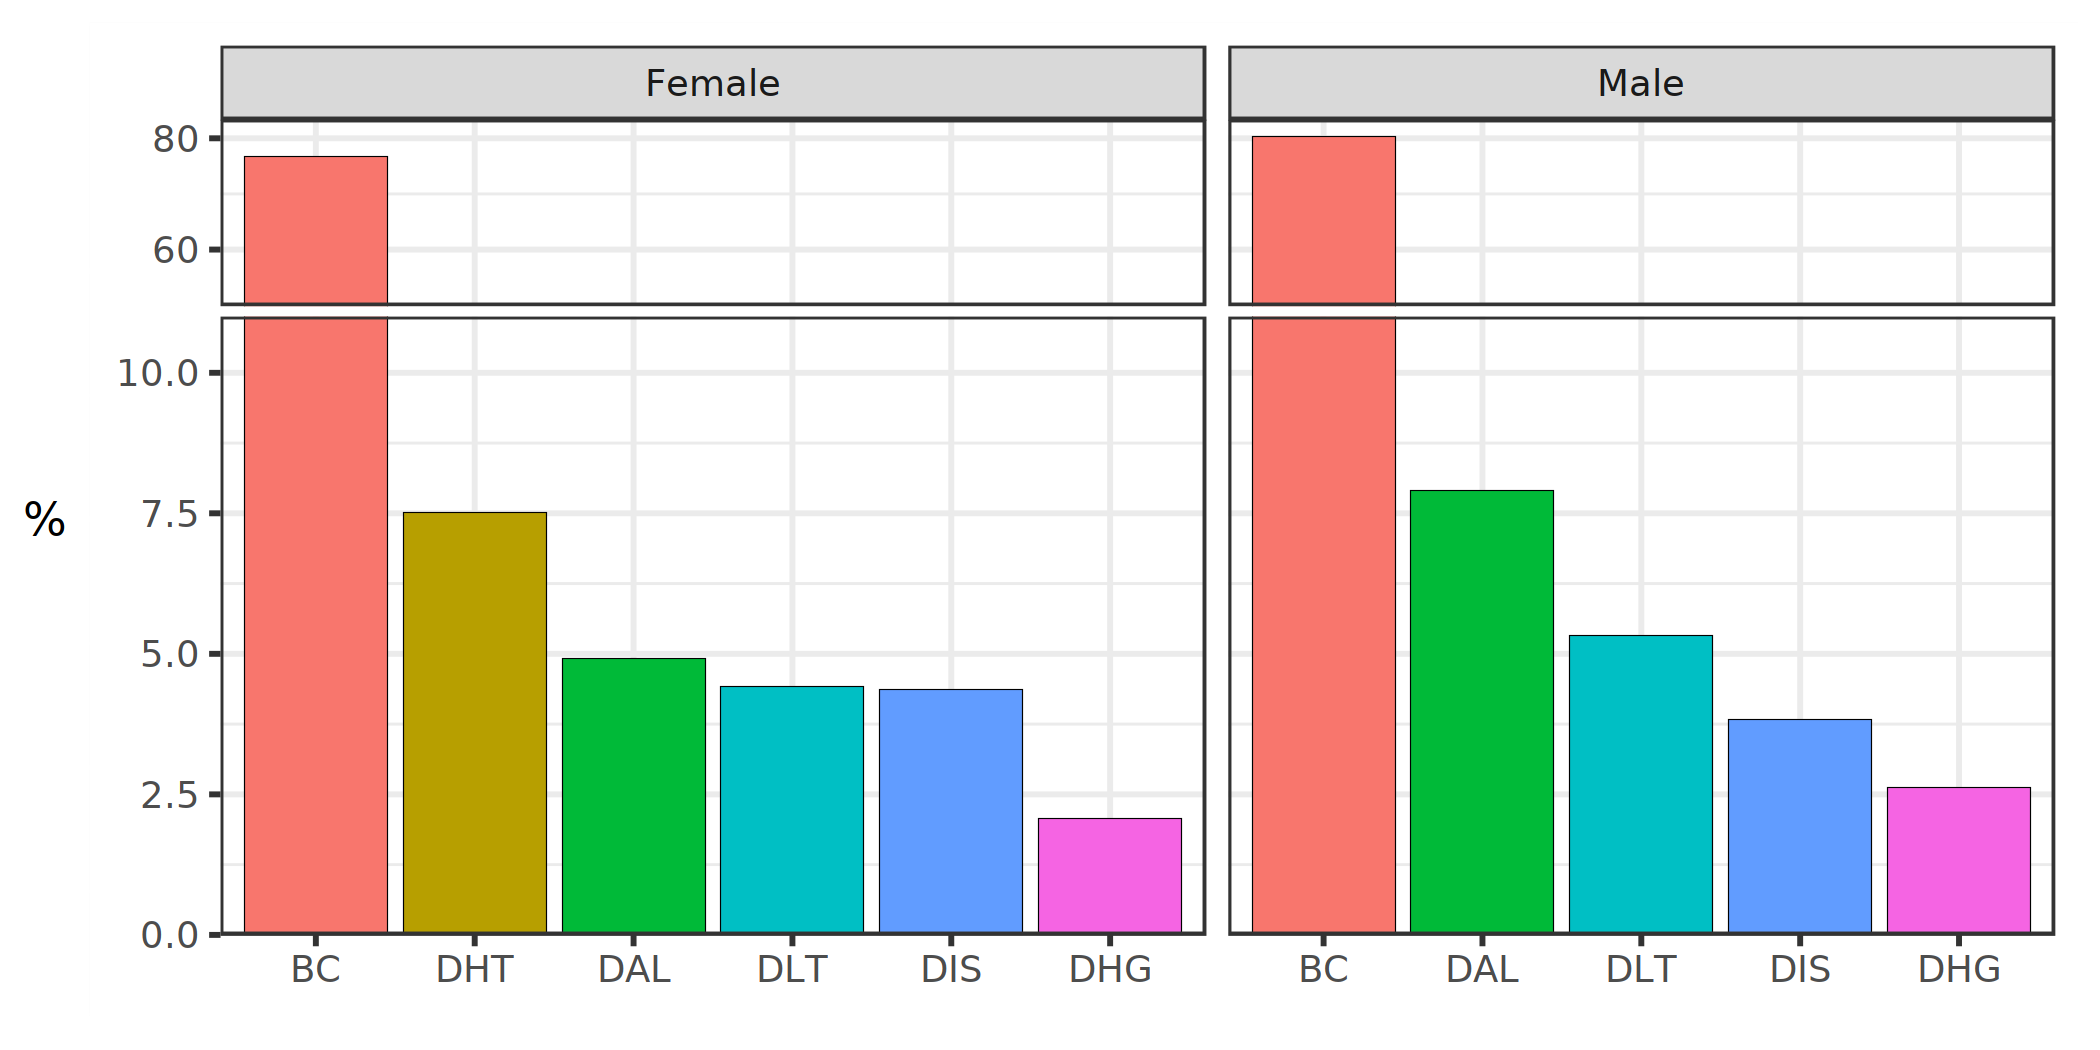

In [295]:
cluswplot <- clusw %>%
    mutate(W = 100*W) %>%
    ggplot(aes(reorder(Cluster, desc(W)), W)) +
    geom_col(aes(fill = ClusCol, group = sex), 
             position = position_dodge(width = .5), 
             color = "black", linewidth = .1) +
    scale_fill_identity() +
    labs(x = NULL, y = "%", title = NULL) +
    ggbreak::scale_y_break(breaks = c(10, 50), space = 0, scales = .3, ticklabels = c(60, 80), expand = expansion(mult = c(0, .1))) +
    facet_grid(~sex, scales = "free", space = "free") +
    theme_bw() +
    theme(
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank(),
        axis.line.y.right = element_blank(),
        axis.title.y = element_text(angle = 0, vjust = .5),
        plot.margin = margin()
    )
cluswplot

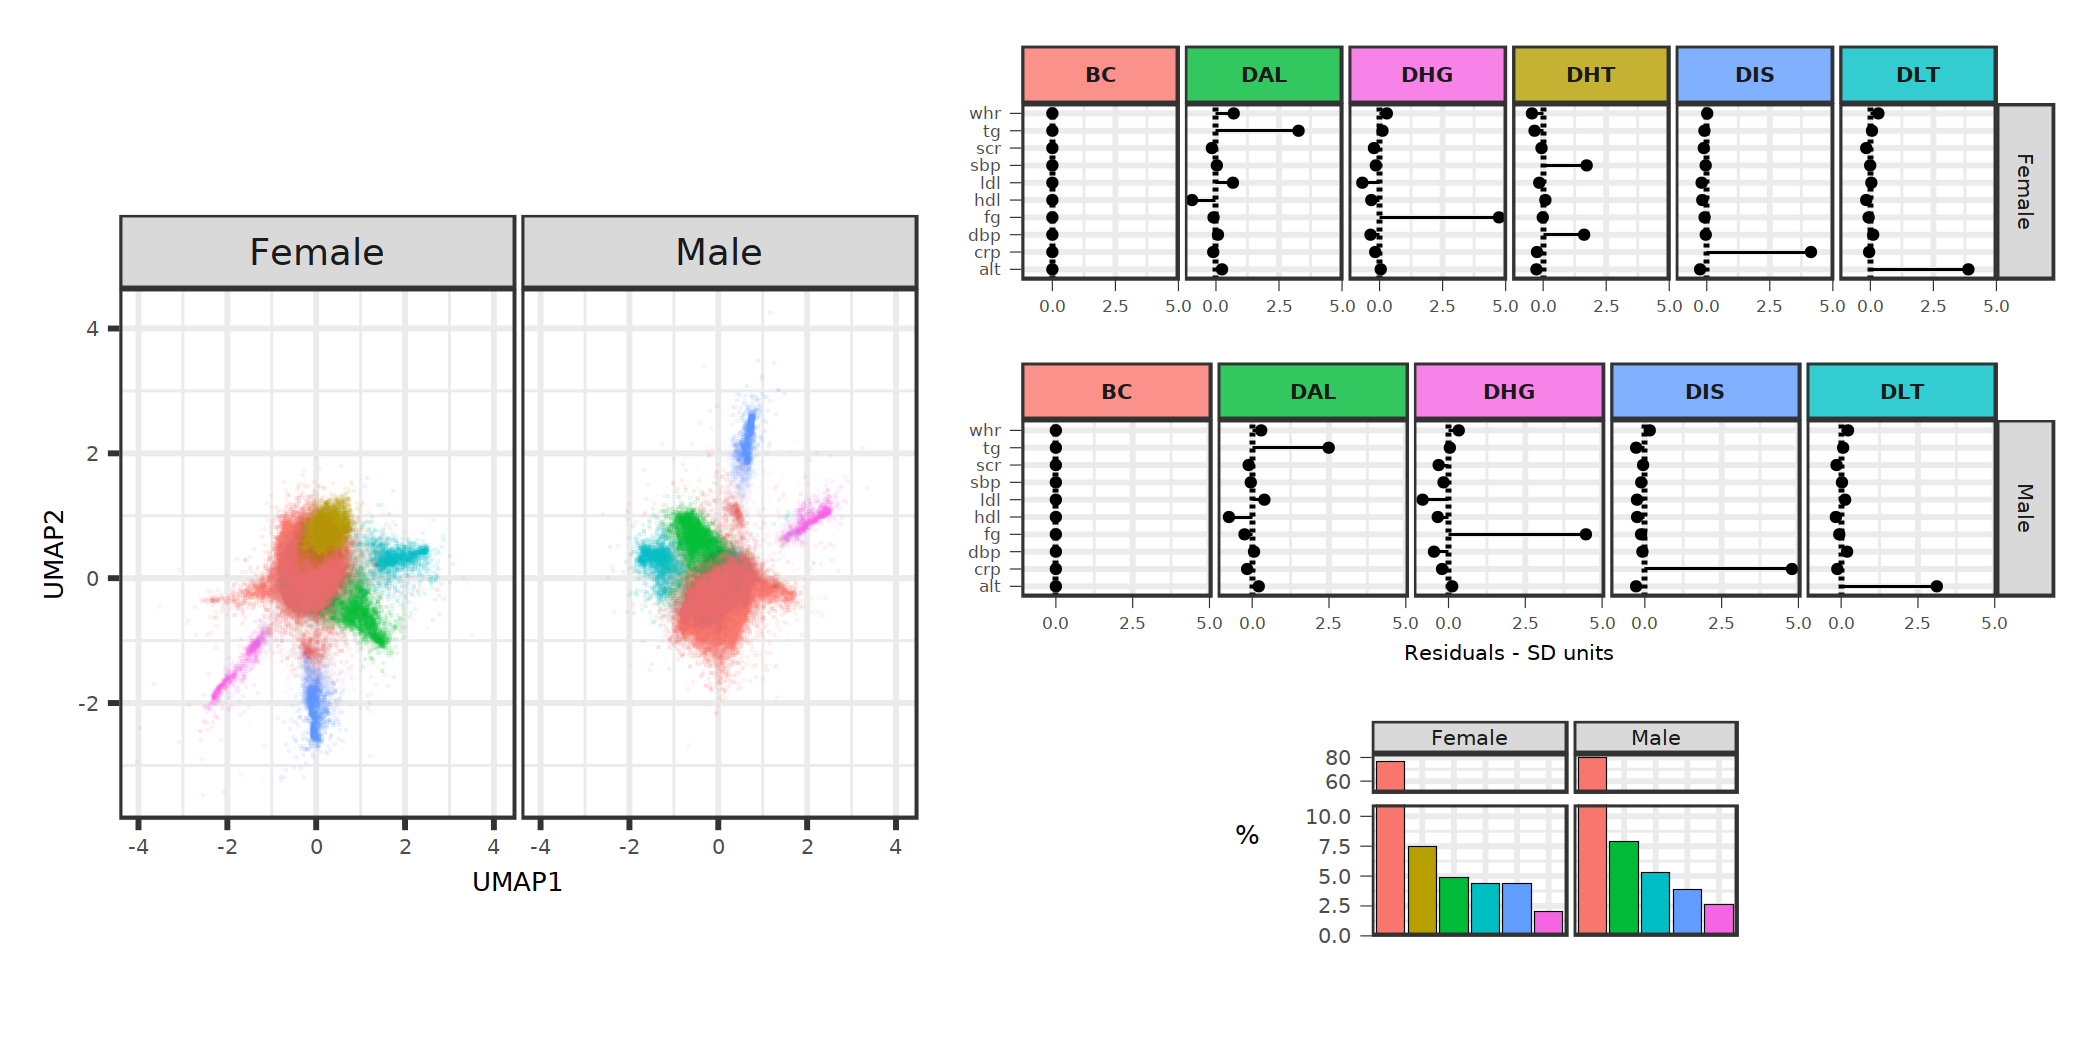

In [296]:
options(repr.plot.width = 7, repr.plot.height = 3.5)
patchwork::wrap_plots(
    patchwork::wrap_plots(
        patchwork::plot_spacer(),
        embedplot +
            theme(
                legend.position = "none",
                axis.title = element_text(size = 6),
                axis.text = element_text(size = 5),
                panel.spacing = unit(.5, "mm")
            ),
        patchwork::plot_spacer(),
        ncol = 1, heights = c(.1,.8,.1)
    ),
    patchwork::wrap_plots(
        cluscentplot &
            theme(
                panel.spacing = unit(.5, "mm"),
                axis.text = element_text(size = 4),
                axis.ticks = element_line(linewidth = .1),
                axis.title.x = element_text(size = 5),
                strip.text = element_text(size = 5),
                strip.text.x = element_text(face = "bold")
            ), 
        patchwork::plot_spacer(),
        patchwork::wrap_plots(
            patchwork::plot_spacer(),
            cluswplot +
                coord_cartesian(ylim = c(0, 8)) +
                theme(
                    axis.text.x = element_blank(),
                    axis.ticks.x = element_blank(),
                    axis.text.y = element_text(size = 5),
                    axis.ticks.y = element_line(linewidth = .1),
                    axis.title.y = element_text(size = 6),
                    strip.text = element_text(size = 5, margin = margin(.5,.5,.5,.5, "mm")),
                    panel.spacing = unit(.5, "mm")
                ),
            patchwork::plot_spacer(),
            nrow = 1, widths = c(.2, .6, .2)
        ),
        ncol = 1, heights = c(.6, -0.1, .4) 
    ),
    widths = c(.45, .55)
)